In [40]:
a = torch.randn(100, 2)
b = torch.randn(200, 2)

In [41]:
# a * b

In [42]:
# a + b

In [43]:
a.dtype  # quantization (in development)

torch.float32

In [44]:
a.shape

torch.Size([100, 2])

In [45]:
b.shape

torch.Size([200, 2])

In [46]:
a = a.unsqueeze(1)
b = b.unsqueeze(0)
a.shape, b.shape

(torch.Size([100, 1, 2]), torch.Size([1, 200, 2]))

In [47]:
a - b  # broadcast

tensor([[[-2.5907,  0.8239],
         [-0.9927, -0.7469],
         [ 0.0848,  0.7481],
         ...,
         [ 0.1272,  0.6186],
         [ 1.3951,  1.9244],
         [-0.1305, -0.1629]],

        [[-1.0497, -1.5182],
         [ 0.5483, -3.0889],
         [ 1.6258, -1.5940],
         ...,
         [ 1.6683, -1.7235],
         [ 2.9361, -0.4177],
         [ 1.4105, -2.5049]],

        [[-2.3037,  1.3609],
         [-0.7057, -0.2098],
         [ 0.3718,  1.2851],
         ...,
         [ 0.4143,  1.1557],
         [ 1.6821,  2.4614],
         [ 0.1565,  0.3742]],

        ...,

        [[-2.5882, -0.0434],
         [-0.9902, -1.6142],
         [ 0.0873, -0.1192],
         ...,
         [ 0.1298, -0.2487],
         [ 1.3976,  1.0571],
         [-0.1280, -1.0302]],

        [[-0.8853, -0.7931],
         [ 0.7128, -2.3638],
         [ 1.7903, -0.8689],
         ...,
         [ 1.8327, -0.9983],
         [ 3.1006,  0.3074],
         [ 1.5749, -1.7798]],

        [[-3.1845,  2.2532],
       

In [48]:
((a - b)**2).sum(-1).shape

torch.Size([100, 200])

In [49]:
def pairwise_distance(a, b):
    diff = a[:, None, :] - b[None, :, :] # Broadcast
    diff_squared = diff ** 2
    return torch.sum(diff_squared, dim=2)


%timeit pairwise_distance(a, b)

347 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Neural Networks

In [51]:
import matplotlib

%matplotlib inline

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)  # FIXME Change 1 to 3 channels
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [53]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


Let's try a random 32x32 input.
Note: expected input size of this net (LeNet) is 32x32. To use this net on
the MNIST dataset, please resize the images from the dataset to 32x32.



In [54]:
input = torch.randn(1, 1, 32, 32)
output = net(input)
print(output)

tensor([[-0.0159,  0.0246, -0.1099, -0.0578, -0.0839,  0.1057, -0.0819,  0.0137,
         -0.0892,  0.0239]], grad_fn=<AddmmBackward>)


In [55]:
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.7826, grad_fn=<MseLossBackward>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [56]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [57]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0108,  0.0018, -0.0102,  0.0008, -0.0104, -0.0040])


In [58]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

.. Note::

      Observe how gradient buffers had to be manually set to zero using
      ``optimizer.zero_grad()``. This is because gradients are accumulated
      as explained in the `Backprop`_ section.



In [59]:
# DataLoader

In [60]:
import torch
import torchvision
import torchvision.transforms as transforms

In [61]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [62]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

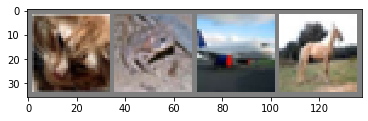

  cat  frog plane horse


In [63]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [64]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [65]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [66]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.885
[1,  6000] loss: 1.673
[1,  8000] loss: 1.556
[1, 10000] loss: 1.487
[1, 12000] loss: 1.469
[2,  2000] loss: 1.386
[2,  4000] loss: 1.358
[2,  6000] loss: 1.358
[2,  8000] loss: 1.335
[2, 10000] loss: 1.343
[2, 12000] loss: 1.296
Finished Training


Files already downloaded and verified


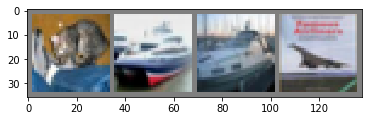

GroundTruth:    cat  ship  ship plane


In [67]:
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4,
    shuffle=False, num_workers=2
)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [68]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship
